<a href="https://colab.research.google.com/github/Chiranjit680/FacialRecognition/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
import cv2
import os
import time
import uuid
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import torch


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models # Corrected import
import torch.nn.functional as F

In [4]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
POS_PATH= os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH= os.path.join('data','anchor')

In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install kaggle


In [10]:
import shutil
import os

# Create kaggle config directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json from Drive to the right place
shutil.copy('/content/drive/MyDrive/kaggle/kaggle.json', '/root/.kaggle/kaggle.json')

# Set file permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [11]:
!kaggle datasets download -d jessicali9530/lfw-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 84% 94.0M/112M [00:00<00:00, 474MB/s]
100% 112M/112M [00:00<00:00, 484MB/s] 


In [12]:
!unzip -q lfw-dataset.zip -d lfw

In [13]:
import os
import shutil

SOURCE_DIR = '/content/lfw/lfw-deepfunneled'  # Change if needed


# Create the destination directory if it doesn't exist
os.makedirs(NEG_PATH, exist_ok=True)

# Iterate through all subdirectories
for person_folder in os.listdir(SOURCE_DIR):
    person_path = os.path.join(SOURCE_DIR, person_folder)
    if os.path.isdir(person_path):
        for file in os.listdir(person_path):
            src_file = os.path.join(person_path, file)
            dst_file = os.path.join(NEG_PATH, file)
            # Handle filename collisions by renaming
            if os.path.exists(dst_file):
                base, ext = os.path.splitext(file)
                i = 1
                while os.path.exists(dst_file):
                    dst_file = os.path.join(NEG_PATH, f"{base}_{i}{ext}")
                    i += 1
            os.replace(src_file, dst_file)  # Use shutil.move() if you want to copy instead


In [14]:
!unzip //content/captured_images.zip -d /content/data/


Archive:  //content/captured_images.zip
   creating: /content/data/captured_images/
  inflating: /content/data/captured_images/image_0.jpg  
  inflating: /content/data/captured_images/image_1.jpg  
  inflating: /content/data/captured_images/image_10.jpg  
  inflating: /content/data/captured_images/image_100.jpg  
  inflating: /content/data/captured_images/image_101.jpg  
  inflating: /content/data/captured_images/image_102.jpg  
  inflating: /content/data/captured_images/image_103.jpg  
  inflating: /content/data/captured_images/image_104.jpg  
  inflating: /content/data/captured_images/image_105.jpg  
  inflating: /content/data/captured_images/image_106.jpg  
  inflating: /content/data/captured_images/image_107.jpg  
  inflating: /content/data/captured_images/image_108.jpg  
  inflating: /content/data/captured_images/image_109.jpg  
  inflating: /content/data/captured_images/image_11.jpg  
  inflating: /content/data/captured_images/image_110.jpg  
  inflating: /content/data/captured_i

In [15]:
import cv2
import os

# Input and output folder paths
input_folder = "/content/data/captured_images"
output_folder = POS_PATH
os.makedirs(output_folder, exist_ok=True)

# Define crop box (y1:y2, x1:x2)
crop_y1, crop_y2 = 250, 490
crop_x1, crop_x2 = 290, 530

# Loop through all image files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):

        # Full path to image
        image_path = os.path.join(input_folder, filename)

        # Read the image
        img = cv2.imread(image_path)

        if img is not None:
            # Crop the image
            cropped = img[crop_y1:crop_y2, crop_x1:crop_x2]

            # Save the cropped image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cropped)

print("✅ All images cropped and saved to:", output_folder)


✅ All images cropped and saved to: data/positive


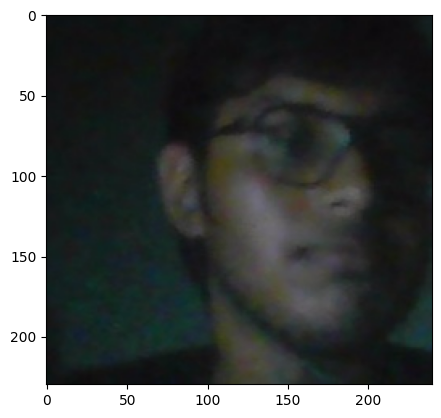

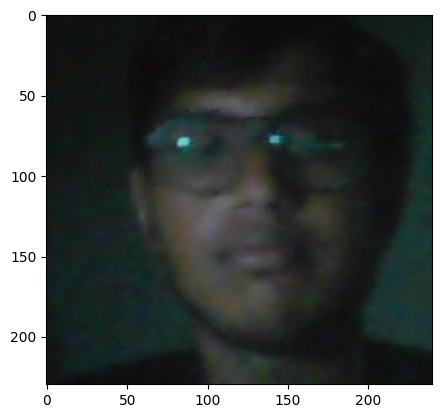

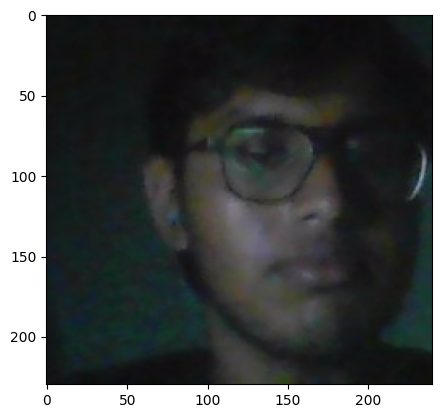

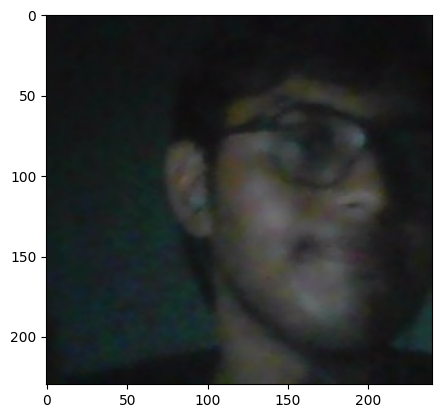

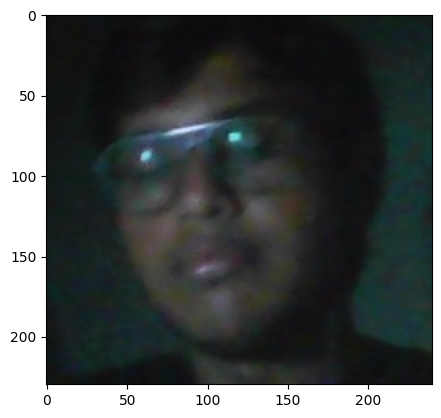

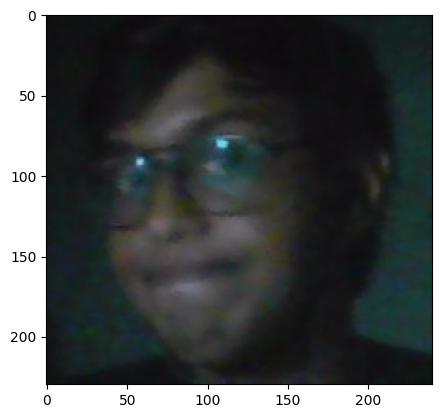

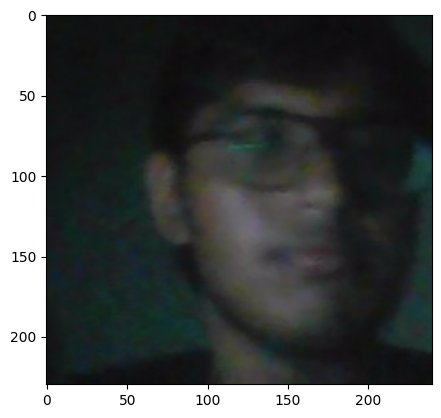

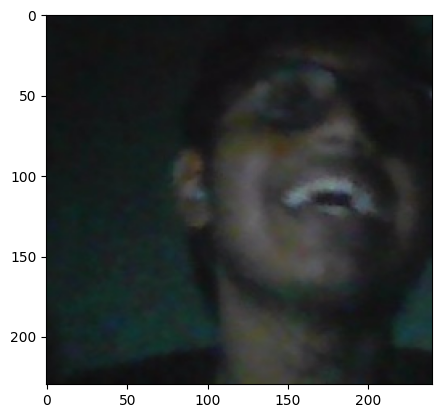

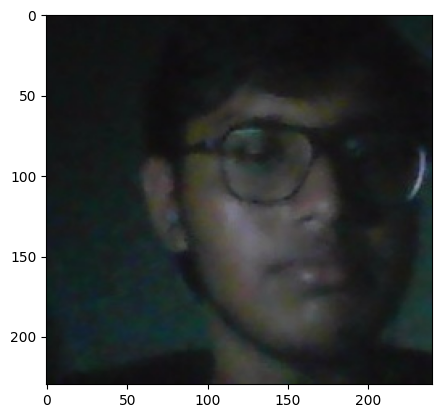

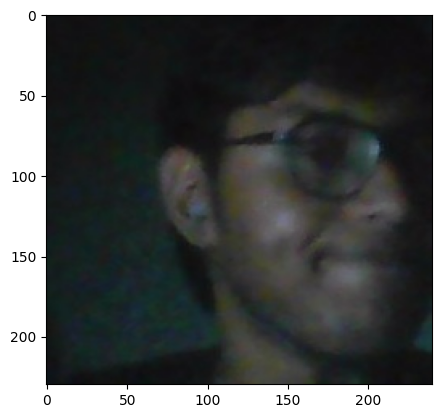

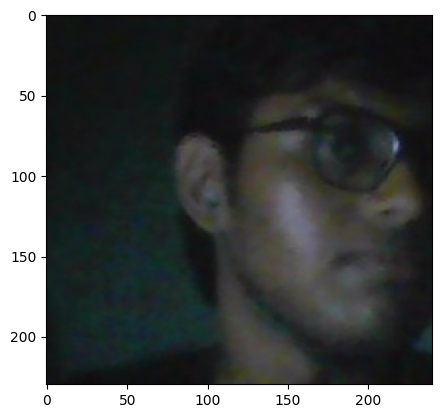

In [16]:
counter=0
for filename in os.listdir(POS_PATH):
  image_path=os.path.join(POS_PATH,filename)
  img = cv2.imread(image_path)

  crop_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(crop_rgb)
  plt.show()
  counter=counter+1
  if counter>10:
    break




In [17]:
!unzip /content/anchor_images.zip -d /content/data/anchor


Archive:  /content/anchor_images.zip
   creating: /content/data/anchor/anchor_images/
  inflating: /content/data/anchor/anchor_images/image_0.jpg  
  inflating: /content/data/anchor/anchor_images/image_1.jpg  
  inflating: /content/data/anchor/anchor_images/image_10.jpg  
  inflating: /content/data/anchor/anchor_images/image_100.jpg  
  inflating: /content/data/anchor/anchor_images/image_101.jpg  
  inflating: /content/data/anchor/anchor_images/image_102.jpg  
  inflating: /content/data/anchor/anchor_images/image_103.jpg  
  inflating: /content/data/anchor/anchor_images/image_104.jpg  
  inflating: /content/data/anchor/anchor_images/image_105.jpg  
  inflating: /content/data/anchor/anchor_images/image_106.jpg  
  inflating: /content/data/anchor/anchor_images/image_107.jpg  
  inflating: /content/data/anchor/anchor_images/image_108.jpg  
  inflating: /content/data/anchor/anchor_images/image_11.jpg  
  inflating: /content/data/anchor/anchor_images/image_12.jpg  
  inflating: /content/dat

In [18]:
import cv2
import os

# Input and output folder paths
input_folder = "/content/data/anchor/anchor_images"
output_folder = "/content/data/anchor"
os.makedirs(output_folder, exist_ok=True)

# Define crop box (y1:y2, x1:x2)
crop_y1, crop_y2 = 250, 490
crop_x1, crop_x2 = 290, 530

# Loop through all image files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):

        # Full path to image
        image_path = os.path.join(input_folder, filename)

        # Read the image
        img = cv2.imread(image_path)

        if img is not None:
            # Crop the image
            cropped = img[crop_y1:crop_y2, crop_x1:crop_x2]

            # Save the cropped image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cropped)

print("✅ All images cropped and saved to:", output_folder)


✅ All images cropped and saved to: /content/data/anchor


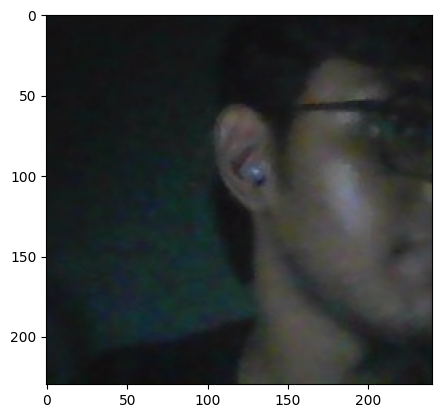

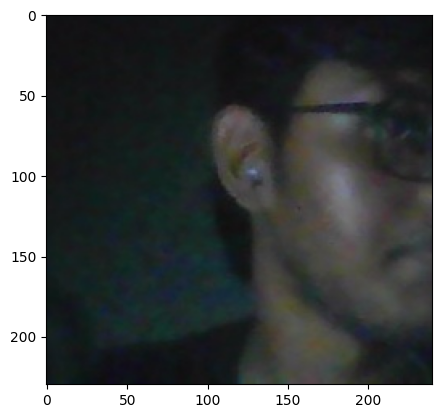

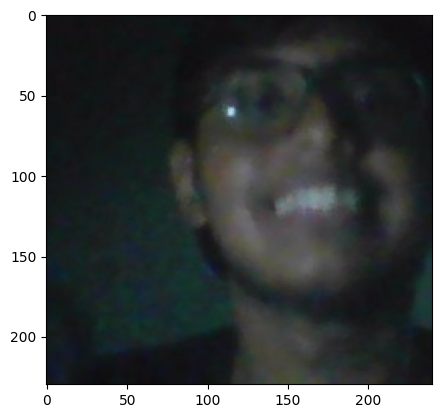

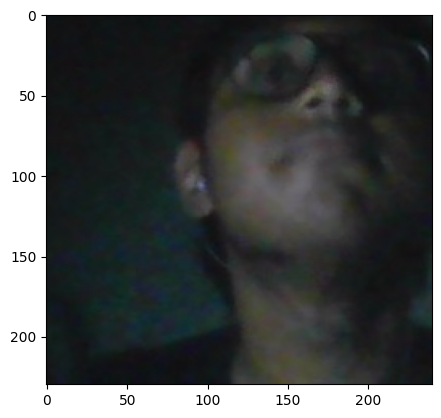

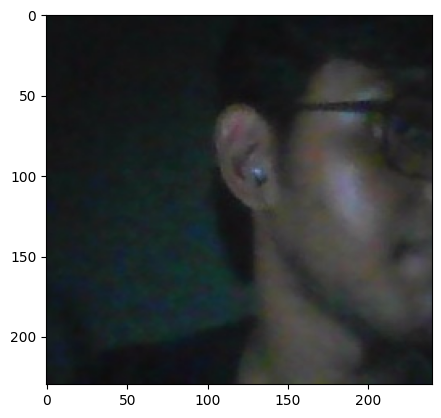

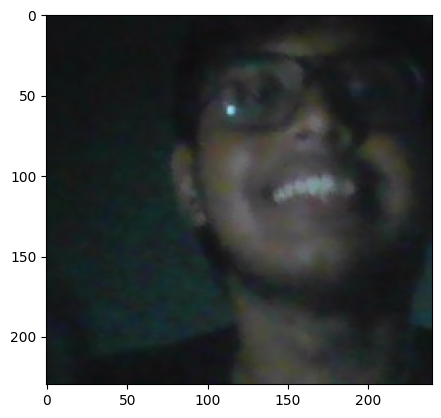

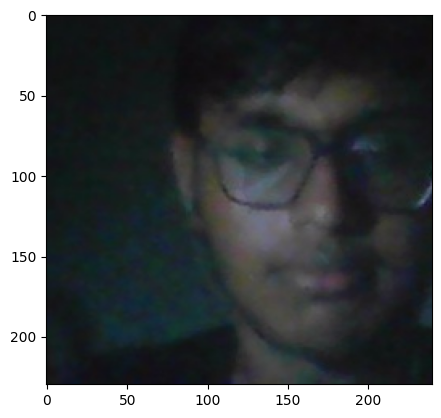

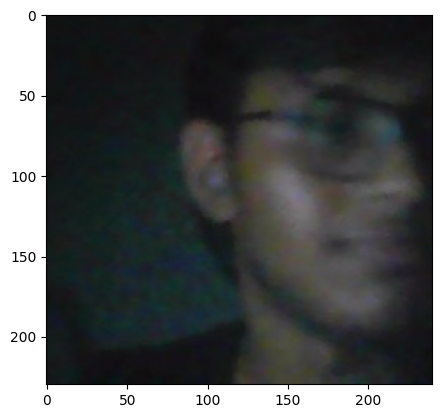

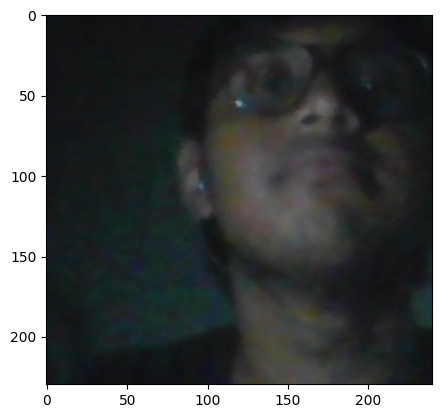

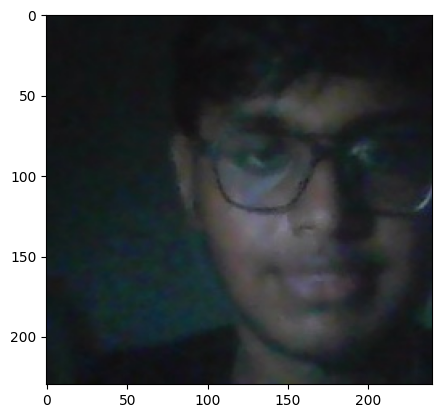

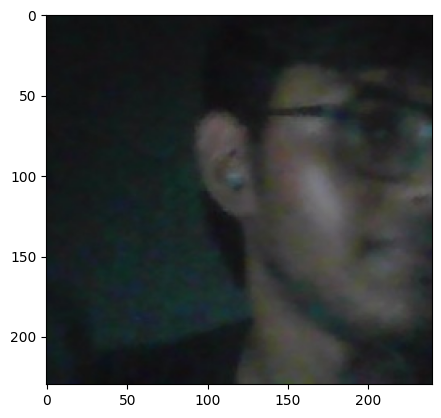

In [19]:
counter=0
for filename in os.listdir(ANC_PATH):
  image_path=os.path.join(ANC_PATH,filename)
  img = cv2.imread(image_path)

  crop_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(crop_rgb)
  plt.show()
  counter=counter+1
  if counter>10:
    break




In [20]:
import glob
import random

# Get all .jpg files
anchor_files = glob.glob(ANC_PATH + '/*.jpg')
positive_files = glob.glob(POS_PATH + '/*.jpg')
negative_files = glob.glob(os.path.join(NEG_PATH, '**', '*.jpg'), recursive=True)


# Shuffle and take first 50
anchor_files = random.sample(anchor_files, min(50, len(anchor_files)))
positive_files = random.sample(positive_files, min(50, len(positive_files)))
negative_files = random.sample(negative_files, min(50, len(negative_files)))

# Check if there are enough files to split


In [21]:
from PIL import Image
from torchvision import transforms
process=transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])
def preprocess_image(file_path):
    img = Image.open(file_path).convert("RGB")  # Read and convert to RGB
    img = process(img)
    return img




In [22]:
processed_anchors = [preprocess_image(path) for path in anchor_files]
processed_positives = [preprocess_image(path) for path in positive_files]
processed_negatives = [preprocess_image(path) for path in negative_files]

In [23]:
from sklearn.model_selection import train_test_split

anchors_train, anchors_test = train_test_split(processed_anchors, test_size=0.2, random_state=42)
positives_train, positives_test = train_test_split(processed_positives, test_size=0.2, random_state=42)
negatives_train, negatives_test = train_test_split(processed_negatives, test_size=0.2, random_state=42)

In [24]:
class PositiveDataset(Dataset):
  def __init__(self, anchors, positives):
    self.anchors = anchors
    self.positives = positives
    self.labels = [1] * len(anchors)

  def __len__(self):
    return len(self.anchors)

  def __getitem__(self, idx):
    return self.anchors[idx], self.positives[idx], self.labels[idx]


In [25]:
class NegativeDataset(Dataset):
  def __init__(self,processed_anchors,processed_negatives):
    self.anchors=processed_anchors
    self.negatives=processed_negatives
    self.labels=[0]*len(processed_negatives)
  def __len__(self):
    return len(self.anchors)
  def __getitem__(self, idx):
    anchor=self.anchors[idx]
    negative=self.negatives[idx]
    label=self.labels[idx]
    return anchor,negative,label



In [26]:
train_pos_dataset=PositiveDataset(anchors_train, positives_train)
test_pos_dataset=PositiveDataset(anchors_test, positives_test)

train_neg_dataset=NegativeDataset(anchors_train, negatives_train)
test_neg_dataset=NegativeDataset(anchors_test, negatives_test)

In [27]:
train_pos_loader=DataLoader(train_pos_dataset,batch_size=16,shuffle=True)
test_pos_loader=DataLoader(test_pos_dataset,batch_size=16,shuffle=True)
train_neg_loader=DataLoader(train_neg_dataset,batch_size=16,shuffle=True)
test_neg_loader=DataLoader(test_neg_dataset,batch_size=16,shuffle=True)

In [28]:
img1=train_pos_dataset[0][0]

img1.shape

torch.Size([3, 100, 100])

In [41]:
import torch
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Dynamically calculate the flattened size
        # Create a dummy input to determine the output shape after convolutions
        dummy_input = torch.randn(1, 3, 100, 100) # Assuming input image size is 3x100x100
        cnn_output_size = self.cnn(dummy_input).shape
        flattened_size = cnn_output_size[1] * cnn_output_size[2] * cnn_output_size[3]


        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 128),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # Flatten the output of the CNN
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [37]:
#distance layer
class L1Distance(nn.Module):
  def __init__(self,eps=1e-6):
    super().__init__()

  def forward(self,input1,input2):
    distance=torch.abs(input1-input2)
    return distance

In [43]:
class SiameseModel(nn.Module):
    def __init__(self, embedding_size=128):
        super(SiameseModel, self).__init__()
        self.embedding_size = embedding_size
        self.siamese_network = SiameseNetwork()
        self.distance_layer = L1Distance()
        # Add a final linear layer to output a single logit
        self.output_layer = nn.Linear(embedding_size, 1)


    def forward(self, input_image, validation_image):
        output1, output2 = self.siamese_network(input_image, validation_image)
        distance = self.distance_layer(output1, output2)
        # Pass the distance through the output layer
        output = self.output_layer(distance).squeeze(-1) # Remove the last dimension if it's 1
        return output  # Can pass to contrastive loss or use for inference

In [39]:
from torch.utils.data import ConcatDataset

# Combine datasets
train_dataset = ConcatDataset([train_pos_dataset, train_neg_dataset])
test_dataset = ConcatDataset([test_pos_dataset, test_neg_dataset])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [44]:
import os
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

model = SiameseModel().to(device)
criterion = nn.BCEWithLogitsLoss()  # Correct loss for logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for anchor, other, label in train_loader:
        anchor = anchor.to(device)
        other = other.to(device)
        label = label.to(device).float()

        outputs = model(anchor, other)  # output shape: (batch_size,)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"{checkpoint_dir}/model_epoch_{epoch+1}.pth")


Epoch [1/100] - Loss: 3.4670
Epoch [2/100] - Loss: 3.4280
Epoch [3/100] - Loss: 3.2677
Epoch [4/100] - Loss: 3.0792
Epoch [5/100] - Loss: 2.7454
Epoch [6/100] - Loss: 2.3635
Epoch [7/100] - Loss: 2.1212
Epoch [8/100] - Loss: 2.0390
Epoch [9/100] - Loss: 1.9988
Epoch [10/100] - Loss: 1.9721
Epoch [11/100] - Loss: 1.9556
Epoch [12/100] - Loss: 1.9436
Epoch [13/100] - Loss: 1.9343
Epoch [14/100] - Loss: 1.9267
Epoch [15/100] - Loss: 1.9206
Epoch [16/100] - Loss: 1.9154
Epoch [17/100] - Loss: 1.9109
Epoch [18/100] - Loss: 1.9064
Epoch [19/100] - Loss: 1.9025
Epoch [20/100] - Loss: 1.8986
Epoch [21/100] - Loss: 1.8948
Epoch [22/100] - Loss: 1.8910
Epoch [23/100] - Loss: 1.8870
Epoch [24/100] - Loss: 1.8825
Epoch [25/100] - Loss: 1.8767
Epoch [26/100] - Loss: 1.8692
Epoch [27/100] - Loss: 1.8555
Epoch [28/100] - Loss: 1.8262
Epoch [29/100] - Loss: 1.7649
Epoch [30/100] - Loss: 1.9182
Epoch [31/100] - Loss: 1.7151
Epoch [32/100] - Loss: 1.6802
Epoch [33/100] - Loss: 1.6350
Epoch [34/100] - Lo

KeyboardInterrupt: 

In [45]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for anchor, other, label in test_loader:
        anchor = anchor.to(device)
        other = other.to(device)
        label = label.to(device).float()

        output = model(anchor, other)
        prediction = torch.sigmoid(output) > 0.5  # Since using BCEWithLogitsLoss
        correct += (prediction.squeeze() == label).sum().item()
        total += label.size(0)

print(f"✅ Accuracy on test set: {correct / total * 100:.2f}%")


✅ Accuracy on test set: 90.00%


In [49]:
# Adjust path to wherever you want in your Drive
model_save_path = "/content/drive/MyDrive/siamese_model.pth"
torch.save(model.state_dict(), model_save_path)


In [50]:
model=SiameseModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/siamese_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>